In [1]:
using LinearAlgebra, Test, DifferentialEquations, SparseArrays, Plots, Parameters, OffsetArrays

In [2]:
# get Q in matrix form for sanity check
function get_Q_matrix(params)
    @unpack θ, cohorts = params
    # intermediate vals
    N = cohorts[1]
    N_total = 2*N;
    setsize = (N+1)^2;
    function get_row_block(d_i,a)    
        # note that all rows sum up to zero by construction
        dl_block = -(z->((N_total-z)/N_total)*θ(a)).(d_i:(d_i+N))
        d_block = -dl_block/2
        du_block = -dl_block/2
        if (d_i == N) # there's no diffusion to 2nd cohort in the last block
            dl_block = dl_block/2
        end

        mat = spdiagm(0 => dl_block, 1 => d_block, (1+N)=>du_block) 

        # modify the last row, where first cohort products are fully recognized
        mat[(N+1),(N+2)] = 0.0
        mat[(N+1),end] *= 2 
        mat[(N+1),:] /= 2 # if departure rate is halved for full recognized state

        # fill the rest in row block with zeros
        if (d_i == 0)
            return [mat[1:(N+1),:] zeros(N+1, (N+1)*(N-1))]
        elseif (d_i >= (N-1))
            return [zeros(N+1, d_i*(N+1)) mat[1:(N+1),:]][:,1:setsize]
        else
            return [zeros(N+1, d_i*(N+1)) mat[1:(N+1),:] zeros(N+1, (N-1-d_i)*(N+1))]
        end
    end
    # generate model
    return a -> vcat(get_row_block.(0:N, a)...)
end

# solve model with matrix Q
function solve_transition_dynamics_matrix(Q_matrix, f_0, T)
    # solve transition dynamics given 
    # Q; N by N matrix generator
    # f_0; N vector of initial distribution
    # T; Float64 terminal time
    df(f,p,a) = Q_matrix(a)' * f
    prob = DifferentialEquations.ODEProblem(df,f_0,(0.0,T))
    return solve(prob);
end

solve_transition_dynamics_matrix (generic function with 1 method)

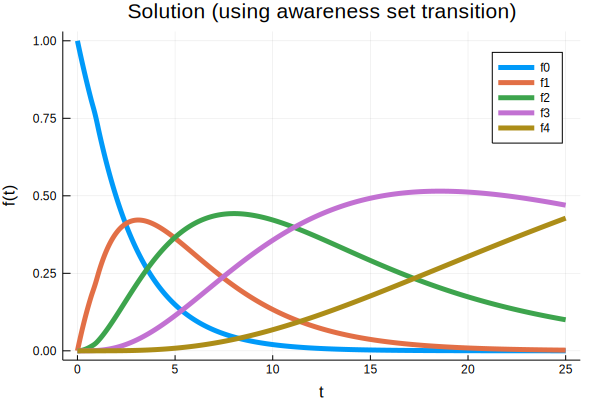

In [3]:
# two firms per cohort
t_2 = 1.0
θ_1 = 0.3
θ_2 = 0.4
θ(t) = t < t_2 ? θ_1 : θ_2
t = 0.0
N = 2
T = 25.0
cohorts = (N, N)
params = (θ = θ, cohorts = cohorts)

# define generator
Q = get_Q_matrix(params)

# solve the corresponding ODE
f_0 = [1.0; fill(0.0, (N+1)^2-1)]
sol_awareness = solve_transition_dynamics_matrix(Q, f_0, T)

# convert to the counting solution
f0_awareness(a) = sol_awareness(a)[1] # no product
# 1.1 or 2.1
f1_awareness(a) = sol_awareness(a)[2] + sol_awareness(a)[4] 
# 1.1+1.2 or 1.1+2.1 or 2.1+2.2
f2_awareness(a) = sol_awareness(a)[3] + sol_awareness(a)[5] + sol_awareness(a)[7]
# 1.1+1.2+2.1 or 1.1+2.1+2.2
f3_awareness(a) = sol_awareness(a)[6] + sol_awareness(a)[8] 
# 1.1+1.2+2.1+2.2
f4_awareness(a) = sol_awareness(a)[9]

# plot
plot(0:0.01:T, [f0_awareness, f1_awareness, f2_awareness, f3_awareness, f4_awareness],linewidth=5,
    title="Solution (using awareness set transition)",
     xaxis="t",yaxis="f(t)",label=["f0" "f1" "f2" "f3" "f4"])

In [4]:
if (N == 2)
   f_awareness(a) = dot(0:2*N, [f0_awareness(a); f1_awareness(a); f2_awareness(a); f3_awareness(a); f4_awareness(a)]) # average product awareness
   plot(0:0.01:T, f_awareness, linewidth=5,
        title="Average product awareness (using awareness set transition, for N = 2)",
        xaxis="t",yaxis="f(t)",label=["f_average"],linecolor="purple") 
    # check if there is no forgetting, i.e., f_count is increasing.
    @test all(diff(f_awareness.(range(0.0, stop = T, length = 50))) .> 0)
end

Test Passed

In [5]:
# sanity checks
# all row sum should be zero
@test all(Q(0.0)*ones((N+1)^2,1) .== 0.0) 

# check if f is a probability distribution for all t in (0, T)
@test all(sum.(sol_awareness.(range(0.0, stop = T, length = 50))) .≈ 1.0)

Test Passed

# Using matrix free operators

In [6]:
using DiffEqOperators 
# solve model without matrix
function solve_transition_dynamics(O!, params, f_0, T; dt = 0.25)
    # unpack params
    @unpack θ, cohorts = params
    N = cohorts[1] # assume that N_t is invariant across all t
        
    # definte the corresponding ODE problem
    prob = ODEProblem(O!,f_0,(0.0,T), params)
    
    # solve the model
    solve(prob, LinearExponential(krylov=:simple), tstops=union(0:dt:T, T))
#     solve(prob, HochOst4(krylov=true), dt=0.1)
end

solve_transition_dynamics (generic function with 1 method)

In [7]:
# helper function for sum of cartesian indices
import Base.sum
sum(I::CartesianIndex) = sum(Tuple(I))
subtract_by_one(I::CartesianIndex, i::Int64, length::Int64) = I - unit_vector(i, length)
function unit_vector(i::Int64, length::Int64)
   v = fill(0, length)
   v[i] = 1
   return CartesianIndex(Tuple(v))
end

# method
function Q_a!(df, f, p, t)
    # unpack params
    @unpack θ, cohorts = p
    N = cohorts[1] # assume that N_t is invariant across all t
    N_total = 2*N;
    setsize = (N+1)^2;
    
    f = reshape(f, (0:N, 0:N))
    df = reshape(df, (0:N, 0:N))
    θ_t = θ(t)
    
    for i in CartesianIndices(f)
        # (outflow)
        df[i] = -((N_total - sum(i)) / N_total) * θ_t * f[i] / 
            (any(Tuple(i) .== N) ? 2 : 1 ) # halve out-flow if fully awared in any cohort 

        # (inflow)
        # if the current status has some awareness in a cohort
        # then there's in-flow from past in the cohort
        for cohort in 1:2
            if (i[cohort] > 0)  
                i_past = subtract_by_one(i, cohort, 2) 
                df[i] += ((N_total + 1 - sum(i)) / N_total) * (θ_t / 2) * f[i_past]
            end
        end
    end
end
# define the corresponding operator
N = cohorts[1] # assume that N_t is invariant across all t
K = length(cohorts) # number of cohorts
setsize = (N+1)^K;
O! = MatrixFreeOperator(Q_a!, (params, 0.0)) # extra argument args=(1,1) is dummy
Base.size(::typeof(O!), n) = n==1 || n == 2 ? setsize : 1
LinearAlgebra.opnorm(::typeof(O!), n::Real) = n==Inf ? 0.1 : nothing
LinearAlgebra.ishermitian(::typeof(O!)) = false

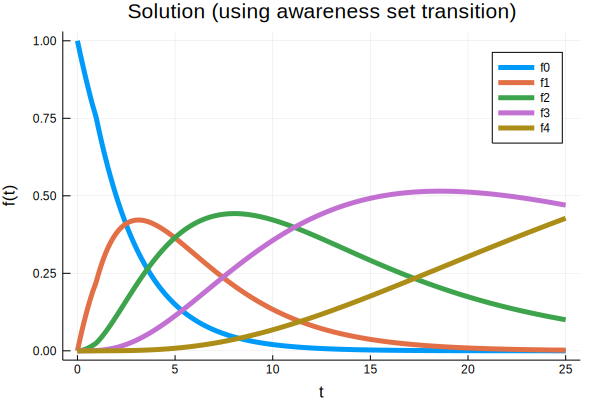

In [8]:
# solve the corresponding ODE
sol_awareness_matrix_free = solve_transition_dynamics(O!, params, f_0, T)

# convert to the counting solution
f0_awareness_matrix_free(a) = sol_awareness_matrix_free(a)[1] # no product
# 1.1 or 2.1
f1_awareness_matrix_free(a) = sol_awareness_matrix_free(a)[2] + sol_awareness_matrix_free(a)[4] 
# 1.1+1.2 or 1.1+2.1 or 2.1+2.2
f2_awareness_matrix_free(a) = sol_awareness_matrix_free(a)[3] + sol_awareness_matrix_free(a)[5] + sol_awareness_matrix_free(a)[7]
# 1.1+1.2+2.1 or 1.1+2.1+2.2
f3_awareness_matrix_free(a) = sol_awareness_matrix_free(a)[6] + sol_awareness_matrix_free(a)[8] 
# 1.1+1.2+2.1+2.2
f4_awareness_matrix_free(a) = sol_awareness_matrix_free(a)[9]

# plot
plot(0:0.01:T, [f0_awareness_matrix_free, f1_awareness_matrix_free, f2_awareness_matrix_free, 
        f3_awareness_matrix_free, f4_awareness_matrix_free],linewidth=5,
    title="Solution (using awareness set transition)",
     xaxis="t",yaxis="f(t)",label=["f0" "f1" "f2" "f3" "f4"])

In [9]:
sum.(sol_awareness_matrix_free.(0:0.1:5))

51-element Array{Float64,1}:
 1.0               
 1.0               
 0.9999999999999999
 1.0               
 1.0               
 1.0000000000000002
 1.0000000000000002
 1.0000000000000002
 1.0000000000000002
 0.9999999999999999
 1.0               
 1.0000000000000004
 1.0000000000000002
 ⋮                 
 1.0000000000000002
 1.0000000000000004
 1.0000000000000002
 1.0000000000000007
 1.0000000000000004
 1.0000000000000004
 1.0000000000000007
 1.0000000000000007
 1.0000000000000007
 1.0000000000000004
 1.0000000000000007
 1.0000000000000004

In [10]:
# check if they yield very close results
@test f0_awareness.(0:0.1:T) ≈ f0_awareness_matrix_free.(0:0.1:T) atol=1e-1
@test f1_awareness.(0:0.1:T) ≈ f1_awareness_matrix_free.(0:0.1:T) atol=1e-1
@test f2_awareness.(0:0.1:T) ≈ f2_awareness_matrix_free.(0:0.1:T) atol=1e-1
@test f3_awareness.(0:0.1:T) ≈ f3_awareness_matrix_free.(0:0.1:T) atol=1e-1
@test f4_awareness.(0:0.1:T) ≈ f4_awareness_matrix_free.(0:0.1:T) atol=1e-1

Test Passed